# Исследование успешности компьютерных игр

## Описание

На основе данных о продажах компьютерных игр за исторический период выявить факторы, влияющие на продажи компьютерных игр и сформировать набор рекомендаций для планирования продаж на очередной год. Составить портрет пользователя по регионам. Проверить гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

## Общая информация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
df = pd.read_csv('datasets/games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В датафрейме 16715 строк данных. 5 столбцов из 11 не имеют пропусков, остальные требуют анализа. Тип для столбца "Год релиза" можно преобразовать в целочисленный. Пользовательский рейтинг нужно преоборазовать в вещественный тип. Скорее всего потребуется лемматизация в поле названия, чтобы выделить семейства игр.

In [4]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN



## Подготовка данных

Переименуем столбцы.

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [7]:
df['year_of_release'].sort_values().unique()

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.,   nan])

Процент пропущеных годов:

In [8]:
'{:.1%}'.format(len(df[(df['year_of_release'].isna()==True)])/len(df))

'1.6%'

Оставим пустые значения, так как мы не можем заменить их никакими усреднёнными и расчётными. В анализе по годам незначительное количество пропущенных значений нам не должно помешать. А также, преобразуем тип в целочисленный, что очевидно.

In [9]:
df['year_of_release'] = df['year_of_release'].astype('Int64')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


In [11]:
df[(df['name'].isna()==True)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Удалим 2 записи, где не указаны названия, жанр и рейтинг. Это не повлияет на исследование

In [12]:
df = df.drop(df[df['name'].isna()==True].index)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB


In [14]:
df['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

В данных жанров проблем нет

In [15]:
df['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

In [16]:
df['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [17]:
len(df[df['user_score']=='tbd'])

2424

Обнаружили значения tbd. Это скорее всего обозначает, что рейтинг ещё не определён (**"tbd"** - To Be Discussed). Заменим на пустые значения, чтобы они не вызывали ошибки при расчётах.

In [18]:
df['user_score'] = df['user_score'].where(df['user_score']!='tbd', np.nan)

In [19]:
len(df[df['user_score']=='tbd'])

0

In [20]:
df['user_score'] = df['user_score'].astype('float')

In [21]:
df['critic_score'].sort_values().unique()

array([13., 17., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
       30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81.,
       82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94.,
       95., 96., 97., 98., nan])

Среди значений нет ни одного вещественного, поэтому можно было бы преобразовать тип в целочисленный, но дальнейший анализ потребует типа float в этом поле.

In [22]:
df['critic_score'] = df['critic_score'].astype('float')

In [23]:
df['critic_score'].describe()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [24]:
df['user_score'].describe()

count    7590.000000
mean        7.125046
std         1.500006
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

Оценки критиков и пользователей являются целью нашего исследования. Поэтому не будем искажать эти данные, заменяя усреднёнными. Так как нам скорее всего придётся делать разные срезы, то лучше избежать внесения изменений без предварительного анализа данных.

In [25]:
df[df['name'].duplicated() == True].sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3862,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN
9507,007: Quantum of Solace,DS,2008,Action,0.11,0.01,0.00,0.01,65.0,NaN,T
4475,007: Quantum of Solace,PS2,2008,Action,0.17,0.00,0.00,0.26,NaN,NaN,NaN
1785,007: Quantum of Solace,PS3,2008,Action,0.43,0.51,0.02,0.19,65.0,6.6,T
3120,007: Quantum of Solace,Wii,2008,Action,0.29,0.28,0.01,0.07,54.0,7.5,T
...,...,...,...,...,...,...,...,...,...,...,...
12648,pro evolution soccer 2011,PC,2010,Sports,0.00,0.05,0.00,0.01,79.0,NaN,NaN
3304,pro evolution soccer 2011,X360,2010,Sports,0.09,0.44,0.00,0.07,79.0,5.9,E
4664,pro evolution soccer 2011,PS2,2010,Sports,0.04,0.21,0.05,0.11,NaN,6.7,E
2583,pro evolution soccer 2011,PSP,2010,Sports,0.05,0.30,0.29,0.16,74.0,5.8,E


В данных обнаружены игры с одинаковыми названиями. Это игры, выпущенные на разных платформах. Этот факт можно использовать для заполнения пропущенных значений.

In [26]:
df_score = pd.pivot_table(df, values=['critic_score', 'user_score'], index=['name'], aggfunc=['mean'])

In [27]:
df_score

mean           
                             critic_score user_score
name                                                
 Tales of Xillia 2                   71.0       7.90
.hack//Infection Part 1              75.0       8.50
.hack//Mutation Part 2               76.0       8.90
.hack//Outbreak Part 3               70.0       8.70
007 Racing                           51.0       4.60
...                                   ...        ...
inFAMOUS: Second Son                 80.0       7.90
nail'd                               65.0       6.65
pro evolution soccer 2011            77.4       6.12
uDraw Studio                         71.0        NaN
uDraw Studio: Instant Artist         54.0       5.70

[5297 rows x 2 columns]

In [28]:
df['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

Можно заполнить рейтинг ESRB для одной и той же игры на разных платформах по рейтингу, присвоенному для других платформ (маловроятно, что он отличается)

In [29]:
df_rating = df[(df['rating'].isna() == False)].groupby(['name','rating'])['rating'].agg(['count']).sort_values('count', ascending=False)

In [30]:
df_rating = df_rating.reset_index()

In [31]:
df_rating

,name,rating,count
0,Madden NFL 07,E,9
1,FIFA 14,E,8
2,The LEGO Movie Videogame,E10+,8
3,Cars,E,8
4,Madden NFL 08,E,8
...,...,...,...
6241,Imagine: Teacher Class Trip,E,1
6242,Imagine: Teacher,E,1
6243,Imagine: Sweet 16,E,1
6244,Imagine: Soccer Captain,E,1


In [32]:
## возвращает рейтинг первой записи в найденных по названию
def get_rating_byname(name):
    rows = df_rating[(df_rating['name']==name)]['rating']
    if len(rows) == 0:
        return np.nan
    else:
        return rows.iloc[0]

In [33]:
def set_rating(row):
    name = row['name']
    rating = row['rating']
    if pd.isnull(rating) == True:
        return get_rating_byname(name)
    else:
        return rating

In [34]:
df['rating'] = df.apply(set_rating, axis=1)

In [35]:
df[df['name'].duplicated() == True].sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3862,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN
9507,007: Quantum of Solace,DS,2008,Action,0.11,0.01,0.00,0.01,65.0,NaN,T
4475,007: Quantum of Solace,PS2,2008,Action,0.17,0.00,0.00,0.26,NaN,NaN,T
1785,007: Quantum of Solace,PS3,2008,Action,0.43,0.51,0.02,0.19,65.0,6.6,T
3120,007: Quantum of Solace,Wii,2008,Action,0.29,0.28,0.01,0.07,54.0,7.5,T
...,...,...,...,...,...,...,...,...,...,...,...
12648,pro evolution soccer 2011,PC,2010,Sports,0.00,0.05,0.00,0.01,79.0,NaN,E
3304,pro evolution soccer 2011,X360,2010,Sports,0.09,0.44,0.00,0.07,79.0,5.9,E
4664,pro evolution soccer 2011,PS2,2010,Sports,0.04,0.21,0.05,0.11,NaN,6.7,E
2583,pro evolution soccer 2011,PSP,2010,Sports,0.05,0.30,0.29,0.16,74.0,5.8,E


In [36]:
df[(df['critic_score'].isna() == False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
...,...,...,...,...,...,...,...,...,...,...,...
16696,Breach,PC,2011,Shooter,0.01,0.00,0.00,0.00,61.0,5.8,T
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.00,0.00,53.0,NaN,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.00,0.00,48.0,NaN,E
16702,STORM: Frontline Nation,PC,2011,Strategy,0.00,0.01,0.00,0.00,60.0,7.2,E10+


In [37]:
df[(df['name'] == 'LMA Manager 2007')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16711,LMA Manager 2007,X360,2006,Sports,0.0,0.01,0.0,0.0,NaN,NaN,NaN


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           10386 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


In [39]:
df.duplicated().sum()

0

Полных дубликатов не обнаружено.

### Суммарные продажи по регионам

In [40]:
df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].describe()

,na_sales,eu_sales,jp_sales,other_sales
count,16713.000000,16713.000000,16713.000000,16713.000000
mean,0.263302,0.145045,0.077625,0.047343
std,0.813565,0.503359,0.308871,0.186742
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


Самые высокие продажи в регионе

In [41]:
df[df['na_sales'] == df['na_sales'].max()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E


В Северной Америке хитом продаж является спортивный симулятор "Wii Sports".

In [42]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [43]:
df[df['total_sales'] == df['total_sales'].max()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54


In [44]:
def set_developer(row):
    platform = row['platform']
    if platform in ['X360', 'XB', 'XOne']:
        return 'Microsoft'
    elif platform in ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']:
        return 'Sony'
    elif platform in ['N64', 'NES', 'SNES', 'DS', '3DS', 'GB','GC', 'GBA', 'Wii', 'WiiU']:
        return 'Nintendo'
    elif platform in ['2600', 'SAT', 'SCD', 'DC', 'GEN']:
        return 'Sega'
    else:
        return 'Other'

In [45]:
df['platform_developer'] = df.apply(set_developer, axis=1)

In [46]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,platform_developer
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,Nintendo
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,Nintendo
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,Nintendo
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,Nintendo
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38,Nintendo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,Sony
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,Microsoft
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,Sony
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,Nintendo


### Выводы

В целом, данные оказались достаточно чистыми и без аномалий. Мы преобразовали типы данных в удобные для работы, удалили для этого мешеающее текстовое значение *tbd* в оценке пользователей. 

Пропущенные значения решено не запонять, так как анализ предполагает различные срезы, где усреднённые цифры уже могут вносить существенные искажения. Заполнили лишь пропущенные категории игр ESRB, воспользовавшись тем, что некоторые игры выпускались на разных платформах.

Мы также подсчитали суммарные продажи и добавили соответствующий столбец в таблицу.
Нашли самую успешную игру всех времён - это спортивный симулятор Wii Sports.
Кроме всего прочего мы добавили столбец с производителями игровых платформ, будет интересно сделать срезы по этому полю.

## Исследовательский анализ данных

### Динамика выпуска игр 

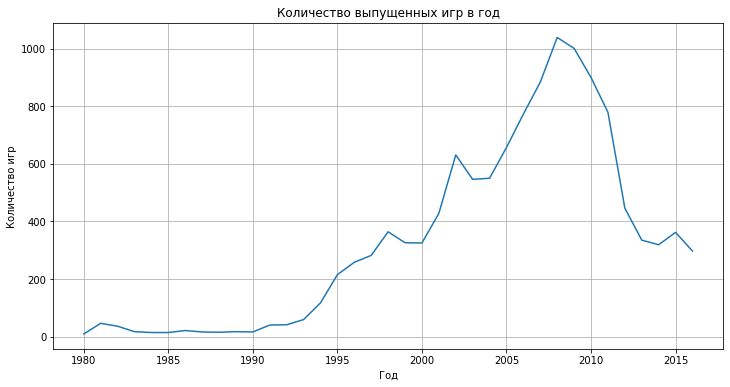

In [47]:
ax = df.groupby('year_of_release')['name'].nunique().plot(figsize=(12,6), grid=True, 
   title='Количество выпущенных игр в год')
ax.set_xlabel("Год")
ax.set_ylabel("Количество игр")
plt.show()

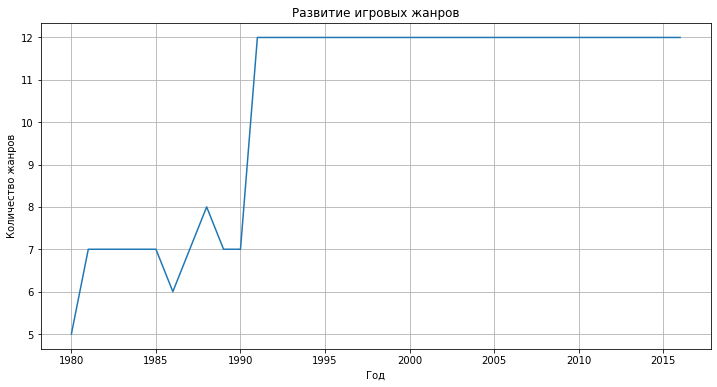

In [48]:
ax = df.groupby('year_of_release')['genre'].nunique().plot(figsize=(12,6), grid=True, 
   title='Развитие игровых жанров')
ax.set_xlabel("Год")
ax.set_ylabel("Количество жанров")
plt.show()

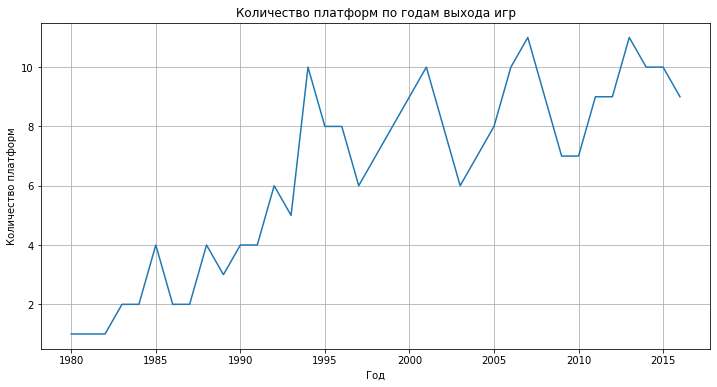

In [49]:
ax = df.groupby('year_of_release')['platform'].nunique().plot(figsize=(12,6), grid=True, 
   title='Количество платформ по годам выхода игр')
ax.set_xlabel("Год")
ax.set_ylabel("Количество платформ")
plt.show()

Можно сказать, что начала бурного развития игр началось в 90х, когда на рынке появились максимальное количество жанров игр. Максимальное количество игр вышло в 2008. К 2016 году количество выпускаемых игр снизилось до уровня 1997 года. Предыдущий период - период формирования рынка игр, не все жанры игр ещё сформировались.

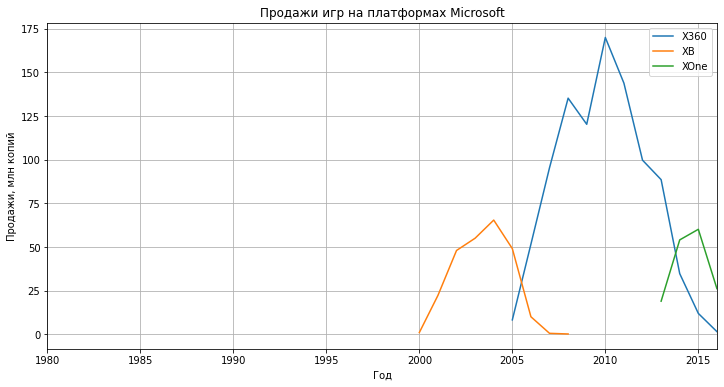

In [50]:
ax = pd.pivot_table(df[df['platform_developer']=='Microsoft'], values=['total_sales'], index=['year_of_release'], columns=['platform'], aggfunc=['sum']).plot(figsize=(12,6), grid=True, 
   title='Продажи игр на платформах Microsoft', xlim=(1980, 2016))
ax.set_xlabel("Год")
ax.set_ylabel("Продажи, млн копий")
ax.legend(['X360', 'XB', 'XOne'])
plt.show()

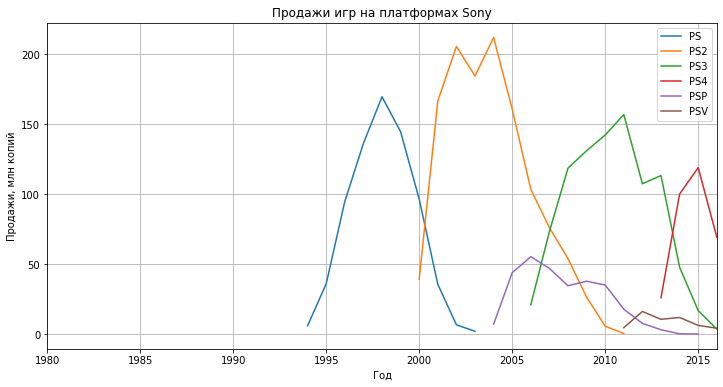

In [51]:
ax = pd.pivot_table(df[df['platform_developer']=='Sony'], values=['total_sales'], index=['year_of_release'], columns=['platform'], aggfunc=['sum']).plot(figsize=(12,6), grid=True, 
   title='Продажи игр на платформах Sony', xlim=(1980, 2016))
ax.set_xlabel("Год")
ax.set_ylabel("Продажи, млн копий")
ax.legend(['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV'])
plt.show()

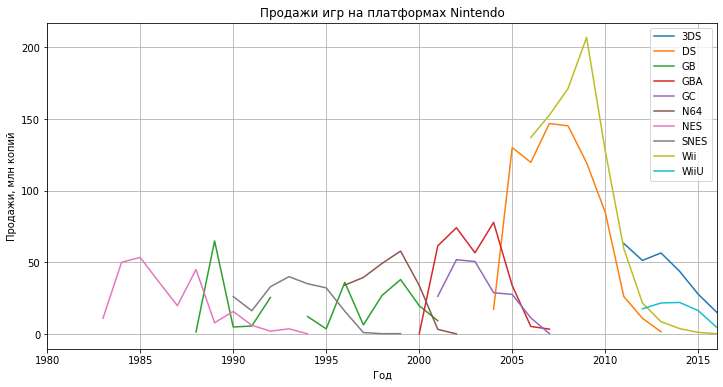

In [52]:
ax = pd.pivot_table(df[df['platform_developer']=='Nintendo'], values=['total_sales'], index=['year_of_release'], columns=['platform'], aggfunc=['sum']).plot(figsize=(12,6), grid=True, 
   title='Продажи игр на платформах Nintendo', xlim=(1980, 2016))
ax.set_xlabel("Год")
ax.set_ylabel("Продажи, млн копий")
ax.legend(['3DS', 'DS', 'GB', 'GBA', 'GC', 'N64', 'NES', 'SNES', 'Wii', 'WiiU'])
plt.show()

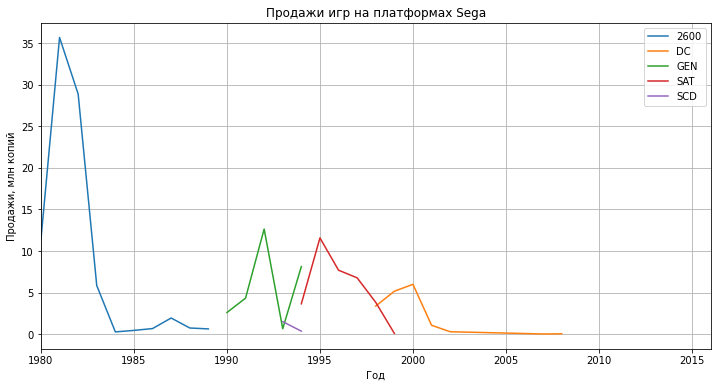

In [53]:
ax = pd.pivot_table(df[df['platform_developer']=='Sega'], values=['total_sales'], index=['year_of_release'], columns=['platform'], aggfunc=['sum']).plot(figsize=(12,6), grid=True, 
   title='Продажи игр на платформах Sega', xlim=(1980, 2016))
ax.set_xlabel("Год")
ax.set_ylabel("Продажи, млн копий")
ax.legend(['2600', 'DC', 'GEN', 'SAT', 'SCD'])
plt.show()

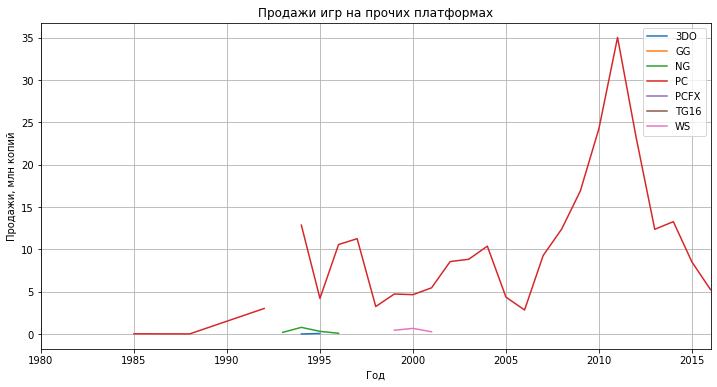

In [54]:
ax = pd.pivot_table(df[df['platform_developer']=='Other'], values=['total_sales'], index=['year_of_release'], columns=['platform'], aggfunc=['sum']).plot(figsize=(12,6), grid=True, 
   title='Продажи игр на прочих платформах', xlim=(1980, 2016))
ax.set_xlabel("Год")
ax.set_ylabel("Продажи, млн копий")
ax.legend(['3DO', 'GG', 'NG', 'PC', 'PCFX', 'TG16', 'WS'])
plt.show()

### Топ-5 платформ по общим продажам

In [55]:
platform_top_5 = pd.pivot_table(df, values=['total_sales'], index=['platform'], aggfunc=['sum']).sort_values(by=( 'sum', 'total_sales'), ascending=False).head(5).reset_index()


In [56]:
platform_top_5.columns = ['platform', 'total_sales']

In [57]:
platform_top_5

,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12


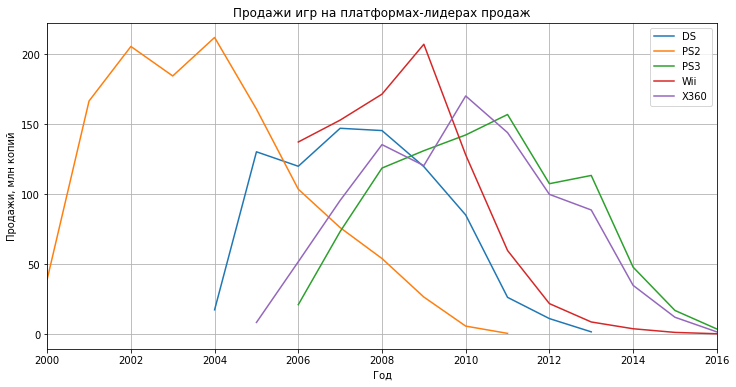

In [58]:
ax = pd.pivot_table(df[df['platform'].isin(platform_top_5['platform'])], values=['total_sales'], index=['year_of_release'], columns=['platform'], aggfunc=['sum']).plot(figsize=(12,6), grid=True, 
   title='Продажи игр на платформах-лидерах продаж', xlim=(2000, 2016))
ax.set_xlabel("Год")
ax.set_ylabel("Продажи, млн копий")
ax.legend(['DS', 'PS2', 'PS3', 'Wii', 'X360'])
plt.show()

Исходя из представленных графиков, можно сделать вывод, что **срок жизни платформы около 10 лет**. Первые пять лет наблюдается рост продаж и затем - спад.

### Актуальный период

Посмотрим, где кончаются хвосты доживающих свой век старых платформ: это 2013 год. Рассмотрим период с **2014 — 2016**, в котором присутствуют только современные платформы, и оценим на нём динамику роста и падения продаж.

In [59]:
actual_period = range(2014,2017)

In [60]:
df_actual = df[df['year_of_release'].isin(actual_period)==True]

In [61]:
df_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,platform_developer
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63,Sony
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,Sony
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68,Nintendo
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,Sony
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98,Sony


### Потенциально прибыльные платформы

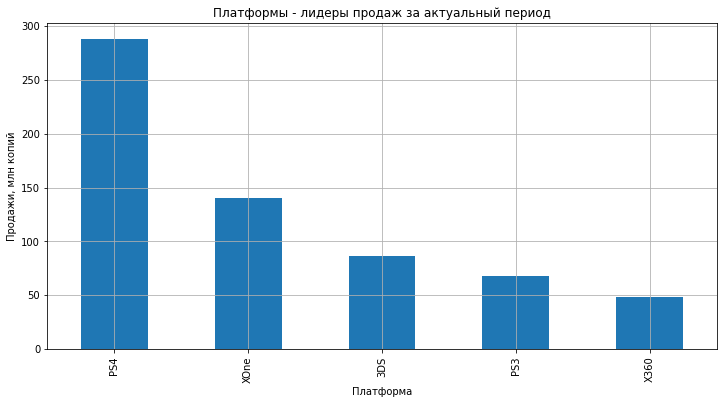

In [62]:
ax = df_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).plot(kind='bar', figsize=(12,6), grid=True, title='Платформы - лидеры продаж за актуальный период')
ax.set_xlabel("Платформа")
ax.set_ylabel("Продажи, млн копий")
plt.show()

In [63]:
pd.pivot_table(df_actual, values=['total_sales'], index=['year_of_release'], columns=['platform'], aggfunc=['sum']).fillna(0)

sum                                                  \
                total_sales                                                   
platform                3DS     PC    PS3     PS4   PSP    PSV   Wii   WiiU   
year_of_release                                                               
2014                  43.76  13.28  47.76  100.00  0.24  11.90  3.75  22.03   
2015                  27.78   8.52  16.82  118.90  0.12   6.25  1.14  16.35   
2016                  15.14   5.25   3.60   69.25  0.00   4.25  0.18   4.60   

                               
                               
platform          X360   XOne  
year_of_release                
2014             34.74  54.07  
2015             11.96  60.14  
2016              1.52  26.15

Исключим из рассмотрения платформы с нулевыми и близкими к нулю продажами в 2016 году

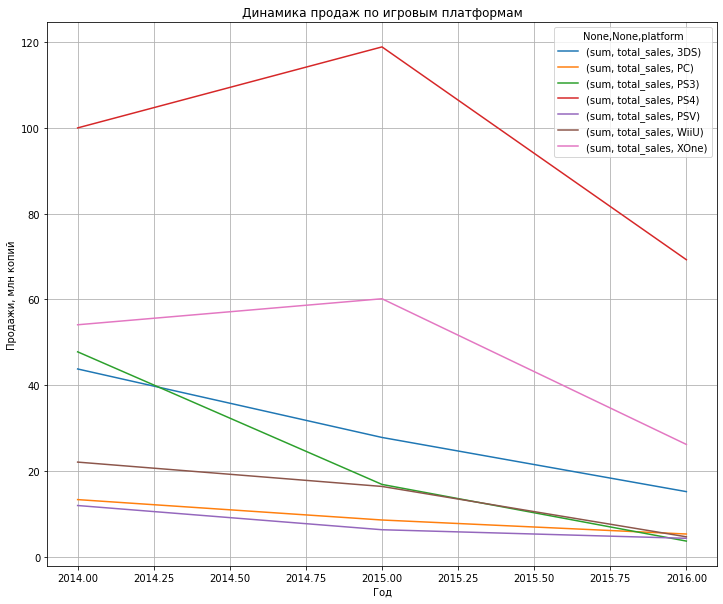

In [64]:
ax = pd.pivot_table(df_actual[df_actual['platform'].isin(['PSP', 'Wii', 'X360'])==False], values=['total_sales'], index=['year_of_release'], columns=['platform'], aggfunc=['sum']).plot(figsize=(12,10), grid=True, 
   title='Динамика продаж по игровым платформам')
ax.set_xlabel("Год")
ax.set_ylabel("Продажи, млн копий")
#ax.legend(df_actual['platform'].sort_values().unique())
plt.show()

Можем отметить положительно платформы **PS4 и XOne**, продажи которых начались в актуальном периоде и имели период роста. Платформа 3DS имеет некоторый остаточный потенциал на продажи в следующем периоде. И незначительный потенциал продаж останется у платформ PC и PSV, они имеют среди прочих наименьшую скорость падения продаж.

In [65]:
df_actual_top5 = pd.pivot_table(df_actual, values=['total_sales'], index=['platform'], aggfunc=['sum']).sort_values(by=('sum', 'total_sales'), ascending=False).head()
df_actual_top5

,sum
,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22


Лучшие по продажам за актуальный период: PS4, XOne, 3DS, PS3, X360

In [66]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

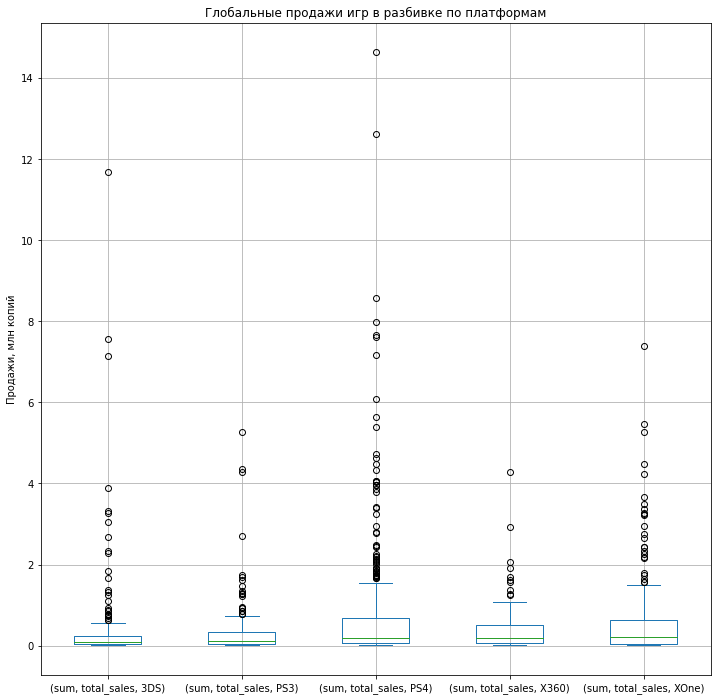

In [67]:
ax = pd.pivot_table(df_actual[df_actual['platform'].isin(df_actual_top5.index)], values=['total_sales'], columns=['platform'], index='name', aggfunc=['sum']).plot(
    figsize=(12,12), grid=True, kind='box',
   title='Глобальные продажи игр в разбивке по платформам')
ax.set_ylabel("Продажи, млн копий")

plt.show()

Распределения очень похожи, можно отметить более выраженные широкие выбросы для 3DS, PS4 и XOne, а также виден более высокий уровень продаж для большинства игр на платформах PS4, X360 и XOne.

### Влияние отзывов пользователей и критиков

Возьмём самую продаваемые платформы в актуальном периоде

In [68]:
for platform in df_actual_top5.index:
    print('Коэффициент корелляции для платформы', platform)
    print('\t', df_actual[df_actual['platform']==platform]['critic_score'].corr(df_actual[df_actual['platform']==platform]['total_sales']))

Коэффициент корелляции для платформы PS4
	 0.4026614106810409
Коэффициент корелляции для платформы XOne
	 0.42867694370333187
Коэффициент корелляции для платформы 3DS
	 0.314117492869051
Коэффициент корелляции для платформы PS3
	 0.44657460493190704
Коэффициент корелляции для платформы X360
	 0.5257228356581523


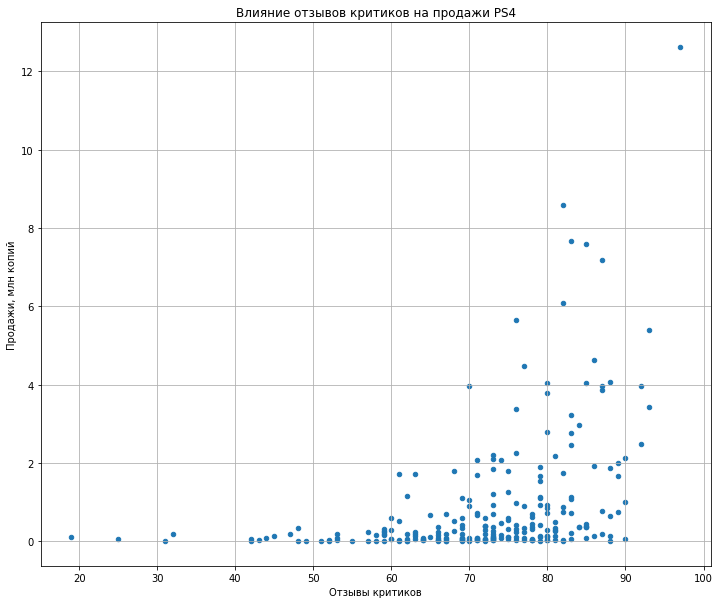

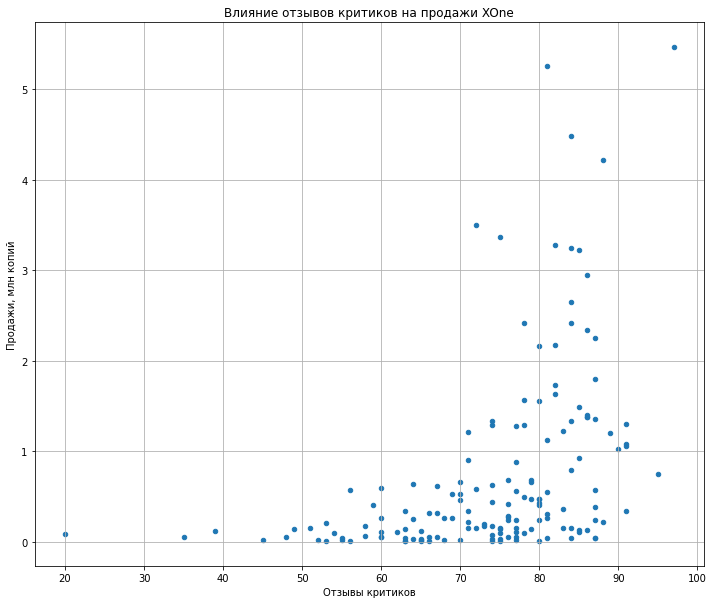

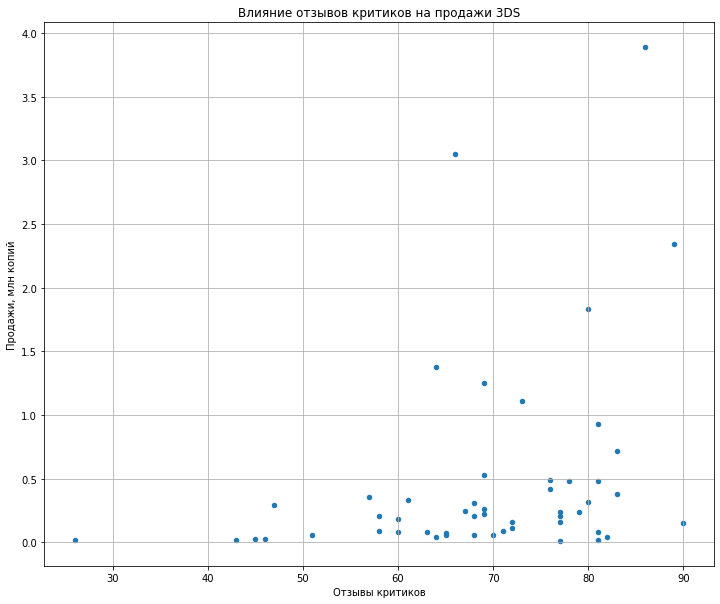

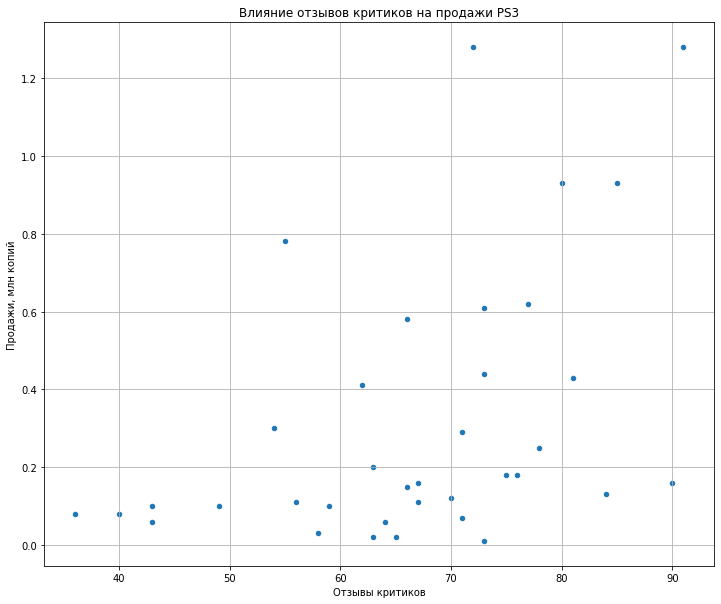

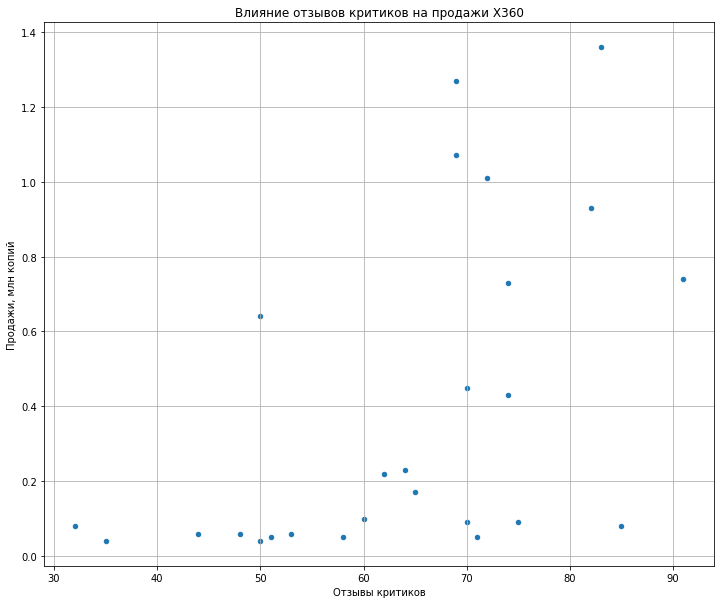

In [69]:
for platform in df_actual_top5.index:
    title = 'Влияние отзывов критиков на продажи ' + platform
    ax = df_actual[df_actual['platform']==platform].plot(
        figsize=(12,10), grid=True, kind='scatter', alpha=1, x='critic_score', y='total_sales', 
        title=title)
    ax.set_xlabel("Отзывы критиков")
    ax.set_ylabel("Продажи, млн копий")
    plt.show()

Несмотря на невысокие коэффициенты корелляции, на графиках можно видеть что, чем выше оценка, тем больше разброс в сторону высоких продаж. Это предположение подкрепляется концентрацией точек внизу для низких оценок пользователей

### Распределение игр по жанрам

In [70]:
pd.pivot_table(df_actual, 
               index=['genre'],
               aggfunc=({'total_sales': 'sum'})).sort_values(by='total_sales', ascending=False).head(7)

,total_sales
genre,
Action,199.36
Shooter,170.94
Sports,109.48
Role-Playing,101.44
Misc,37.55
Fighting,28.22
Racing,27.52


In [71]:
pd.pivot_table(df_actual, 
               index=['genre'],
               aggfunc=({'name': 'count'})).sort_values(by='name', ascending=False).head(7)

,name
genre,
Action,619
Role-Playing,221
Adventure,185
Sports,161
Shooter,128
Misc,113
Racing,69


**Самые прибыльные жанры: Action, Shooter, Sports**. 
По количеству выпущенных игр лидеры немного другие: **Action, Role-Playing, Adventure**.

In [72]:
pd.pivot_table(df_actual, 
               index=['genre'],
               aggfunc=({'total_sales': 'sum'})).sort_values(by='total_sales', ascending=True).head(5)

,total_sales
genre,
Puzzle,2.21
Strategy,3.96
Simulation,13.13
Adventure,17.55
Platform,18.09


Есть и **лидеры по низким продажам: Strategy, Adventure и Puzzle.** Игры, где требуется усидчивость и вдумчивость, не так привлекательны для массового пользователя.

In [73]:
pd.pivot_table(df_actual, values='total_sales',
               index='genre',
               aggfunc='mean').sort_values(by='total_sales', ascending=False).head(5)

,total_sales
genre,
Shooter,1.335469
Sports,0.680000
Platform,0.476053
Fighting,0.470333
Role-Playing,0.459005


In [74]:
pd.pivot_table(df_actual, values='total_sales',
               index='genre',
               aggfunc='mean').sort_values(by='total_sales', ascending=True).head(5)

,total_sales
genre,
Adventure,0.094865
Strategy,0.107027
Puzzle,0.157857
Simulation,0.298409
Action,0.322068


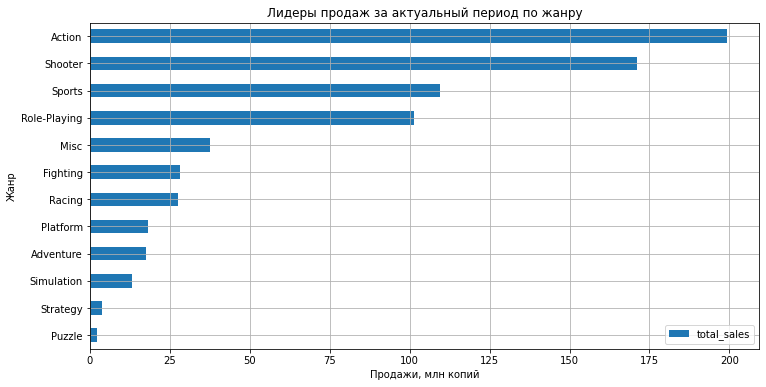

In [75]:
ax = pd.pivot_table(df_actual, 
               index=['genre'],
               aggfunc=({'total_sales': 'sum'})).sort_values(by='total_sales', ascending=True).plot(kind='barh', figsize=(12,6), grid=True, 
                title='Лидеры продаж за актуальный период по жанру')
ax.set_ylabel("Жанр")
ax.set_xlabel("Продажи, млн копий")
plt.show()

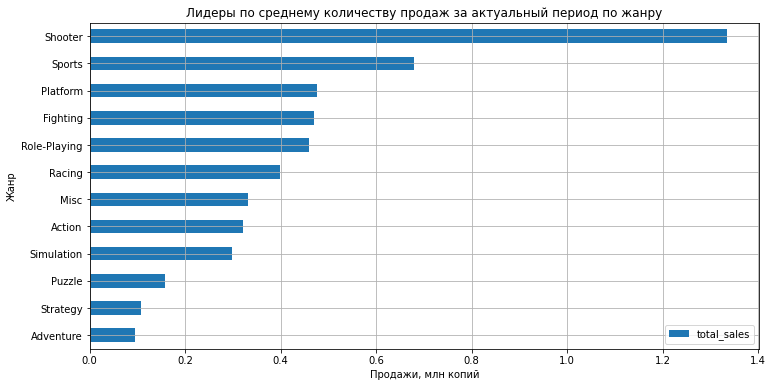

In [76]:
ax = pd.pivot_table(df_actual, 
               index=['genre'],
               aggfunc=({'total_sales': 'mean'})).sort_values(by='total_sales', ascending=True).plot(kind='barh', figsize=(12,6), grid=True, 
                title='Лидеры по среднему количеству продаж за актуальный период по жанру')
ax.set_ylabel("Жанр")
ax.set_xlabel("Продажи, млн копий")
plt.show()

Самые продаваемые жанры по среднему количеству продаж: **Shooter, Sports**. **Shooter** - всегда в топе. 

### Вывод

Мы проследили историю становления рынка компьютерных игр до 2008 и падение продаж до последнего времени.

Определили топ-5 платформ за всю историю: PS2, X360, PS3, Wii, DS

Мы определили актуальный период времени 2014-2016,  в котором представлены игры на современных платформах. И провели по ним исследование.

Оценены потенциально прибыльные платформы: PS4 и XOne

Выяснилось, что высокие оценки пользователей влияют на продажи

Определены самые прибыльные жанры: Action, Shooter, Sports

Самые высокие средние продажи: Shooter, Sports

Самые низкодоходные жанры по всем статьям: Adventure, Strategy, Puzzle, Simulation

## Портрет пользователя

Будем ориентироваться на актуальный период.

###  Северная Америка

#### Топ-5 популярных платформ

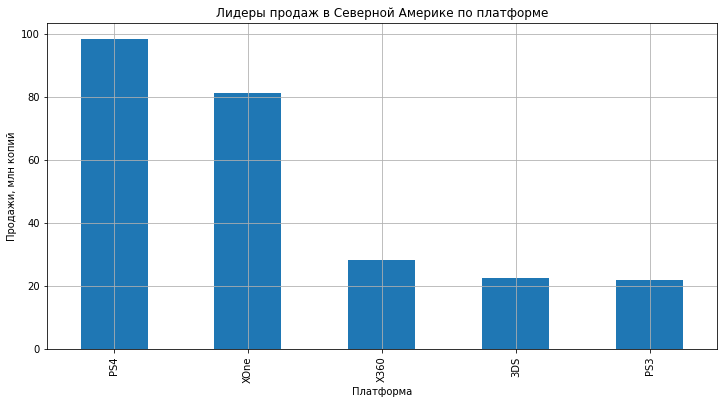

In [77]:
ax = df_actual.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5).plot(
    kind='bar', figsize=(12,6), grid=True, 
    title='Лидеры продаж в Северной Америке по платформе')
ax.set_xlabel("Платформа")
ax.set_ylabel("Продажи, млн копий")
plt.show()

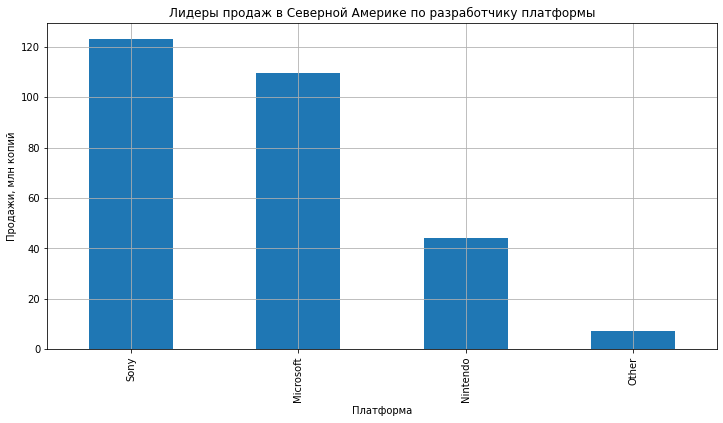

In [78]:
ax = df_actual.groupby('platform_developer')['na_sales'].sum().sort_values(ascending=False).head(5).plot(
    kind='bar', figsize=(12,6), grid=True, 
    title='Лидеры продаж в Северной Америке по разработчику платформы')
ax.set_xlabel("Платформа")
ax.set_ylabel("Продажи, млн копий")
plt.show()

Борются за лидерство платформы от Sony и Microsoft, доля остальных - небольшая

#### Топ-5 популярных жанров

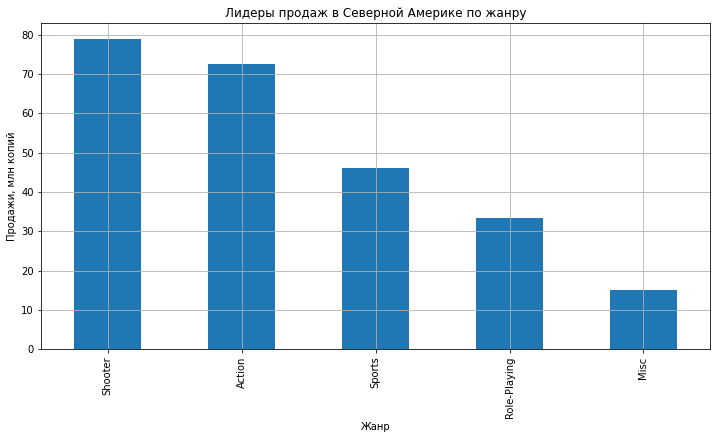

In [79]:
ax = df_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5).plot(
    kind='bar', figsize=(12,6), grid=True, 
    title='Лидеры продаж в Северной Америке по жанру')
ax.set_xlabel("Жанр")
ax.set_ylabel("Продажи, млн копий")
plt.show()

Лидеры с заметным отрывом жанры Shooter и Action

#### Влияние рейтинга ESRB

In [80]:
(df_actual.groupby('rating')['total_sales'].sum() / df_actual[df_actual['rating'].isna()==False]['total_sales'].sum() * 100).sort_values(ascending=False)

rating
M       44.084308
E       23.891983
T       18.560966
E10+    13.462744
Name: total_sales, dtype: float64

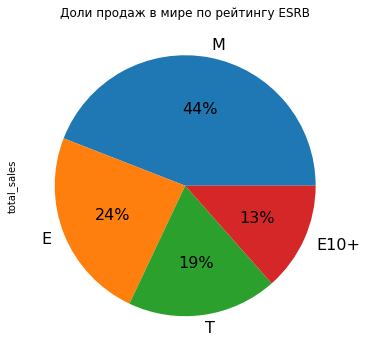

In [81]:
ax = (df_actual.groupby('rating')['total_sales'].sum() / df_actual[df_actual['rating'].isna()==False]['total_sales'].sum()).sort_values(ascending=False).plot(
    kind='pie', figsize=(12,6), autopct=lambda p: '{:.0f}%'.format(p), fontsize=16,
    title='Доли продаж в мире по рейтингу ESRB')
plt.show()

In [82]:
(df_actual.groupby('rating')['na_sales'].sum() / df_actual[df_actual['rating'].isna()==False]['na_sales'].sum() * 100).sort_values(ascending=False)

rating
M       45.348180
E       22.078205
T       17.519899
E10+    15.053717
Name: na_sales, dtype: float64

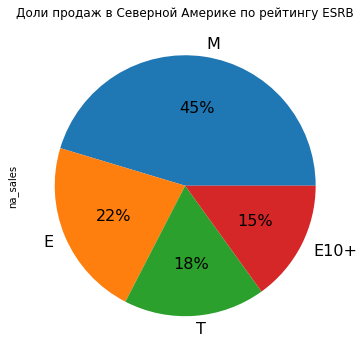

In [83]:
ax = (df_actual.groupby('rating')['na_sales'].sum() / df_actual[df_actual['rating'].isna()==False]['na_sales'].sum()).sort_values(ascending=False).plot(
    kind='pie', figsize=(12,6), autopct=lambda p: '{:.0f}%'.format(p), fontsize=16,
    title='Доли продаж в Северной Америке по рейтингу ESRB')
plt.show()

Доли игр в зависимости от рейтинга в целом не отличаются от мировых. Почти половина это игры категории 17+, почти четверть - для всех и остальные - категории для подростков.

### Европа

#### Топ-5 популярных платформ

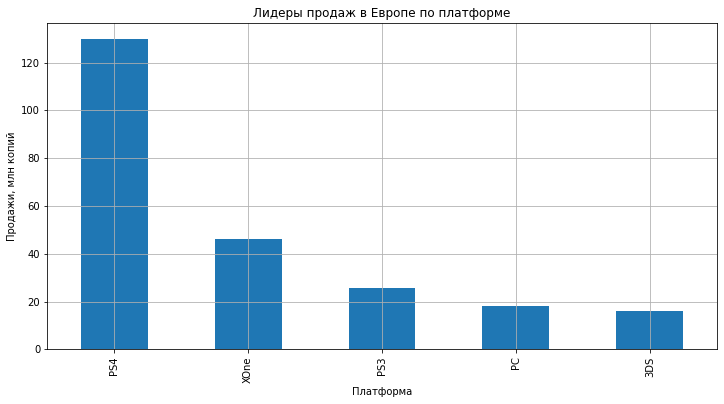

In [84]:
ax = df_actual.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5).plot(
    kind='bar', figsize=(12,6), grid=True, 
    title='Лидеры продаж в Европе по платформе')
ax.set_xlabel("Платформа")
ax.set_ylabel("Продажи, млн копий")
plt.show()

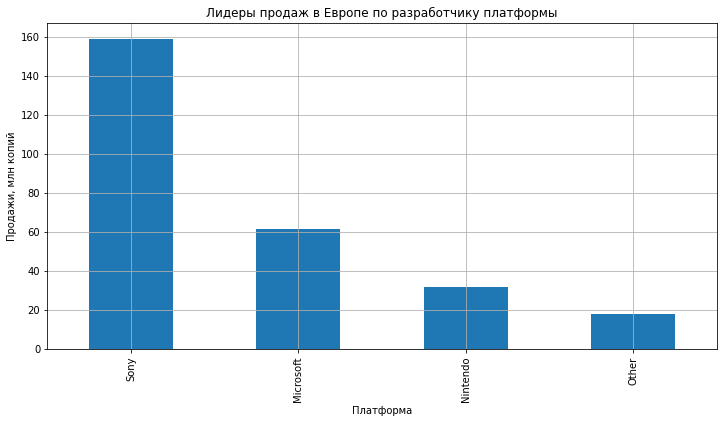

In [85]:
ax = df_actual.groupby('platform_developer')['eu_sales'].sum().sort_values(ascending=False).head(5).plot(
    kind='bar', figsize=(12,6), grid=True, 
    title='Лидеры продаж в Европе по разработчику платформы')
ax.set_xlabel("Платформа")
ax.set_ylabel("Продажи, млн копий")
plt.show()

В Европе лидируют платформы от Sony.

#### Топ-5 популярных жанров

In [86]:
df_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)

genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Name: eu_sales, dtype: float64

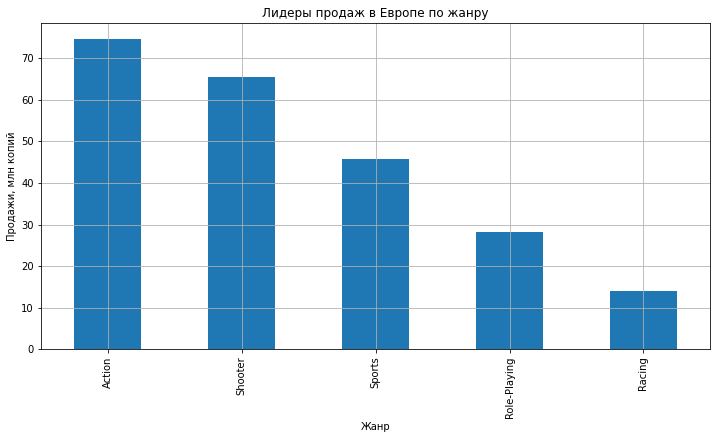

In [87]:
ax = df_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5).plot(
    kind='bar', figsize=(12,6), grid=True, 
    title='Лидеры продаж в Европе по жанру')
ax.set_xlabel("Жанр")
ax.set_ylabel("Продажи, млн копий")
plt.show()

В Европе вкусы игроков почти совпадают с американцами, с той лишь разницей, что тут немного больше любят гонки.

#### Влияние рейтинга ESRB

In [88]:
(df_actual.groupby('rating')['eu_sales'].sum() / df_actual[df_actual['rating'].isna()==False]['eu_sales'].sum() * 100).sort_values(ascending=False)

rating
M       45.670598
E       26.128873
T       15.842339
E10+    12.358190
Name: eu_sales, dtype: float64

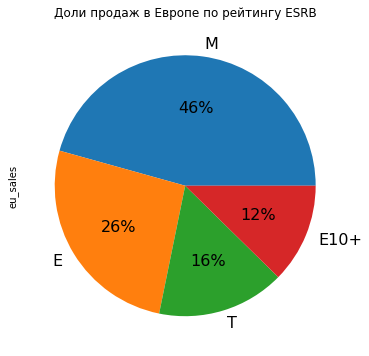

In [89]:
ax = (df_actual.groupby('rating')['eu_sales'].sum() / df_actual[df_actual['rating'].isna()==False]['eu_sales'].sum()).sort_values(ascending=False).plot(
    kind='pie', figsize=(12,6), autopct=lambda p: '{:.0f}%'.format(p), fontsize=16,
    title='Доли продаж в Европе по рейтингу ESRB')
plt.show()

Распределение по возрастным категориям такое же как в Северной Америке,  почти половина игры для категории 17+

### Япония

#### Топ-5 популярных платформ

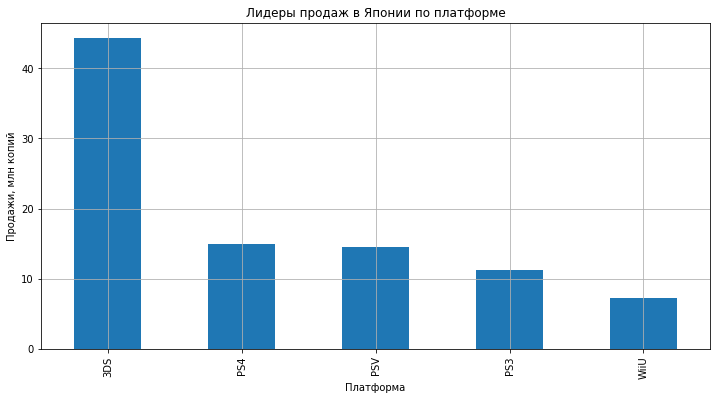

In [90]:
ax = df_actual.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5).plot(
    kind='bar', figsize=(12,6), grid=True, 
    title='Лидеры продаж в Японии по платформе')
ax.set_xlabel("Платформа")
ax.set_ylabel("Продажи, млн копий")
plt.show()

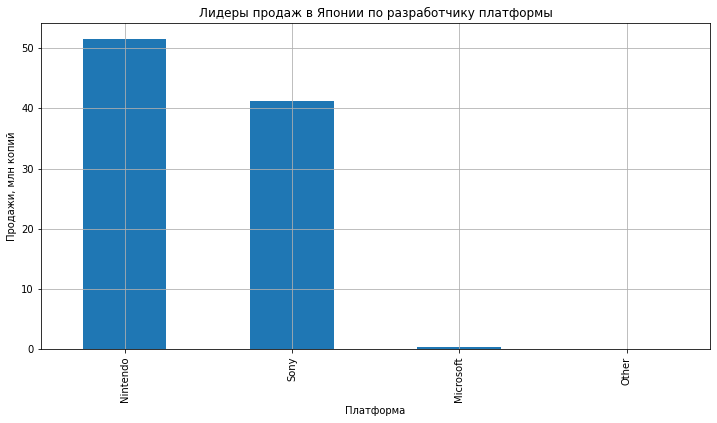

In [91]:
ax = df_actual.groupby('platform_developer')['jp_sales'].sum().sort_values(ascending=False).head(5).plot(
    kind='bar', figsize=(12,6), grid=True, 
    title='Лидеры продаж в Японии по разработчику платформы')
ax.set_xlabel("Платформа")
ax.set_ylabel("Продажи, млн копий")
plt.show()

В японии два гиганта борются за лидерство Nintendo и Sony, традиционные лидеры того региона. Доля остальных ничтожна.

#### Топ-5 популярных жанров

In [92]:
df_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Name: jp_sales, dtype: float64

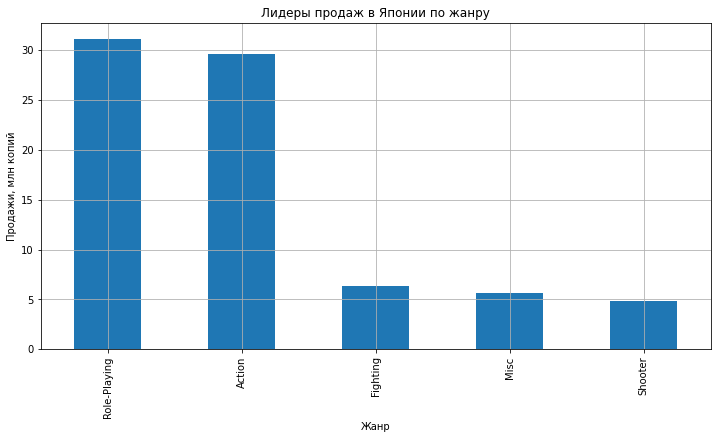

In [93]:
ax = df_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5).plot(
    kind='bar', figsize=(12,6), grid=True, 
    title='Лидеры продаж в Японии по жанру')
ax.set_xlabel("Жанр")
ax.set_ylabel("Продажи, млн копий")
plt.show()

В Японии в отличие от Европы и Северной Америки лидируют ролевые игры и игры в жанре Action. Остальные занимают одинаково небольшие доли.

#### Влияние рейтинга ESRB

In [94]:
(df_actual.groupby('rating')['jp_sales'].sum() / df_actual[df_actual['rating'].isna()==False]['jp_sales'].sum() * 100).sort_values(ascending=False)

rating
T       42.132505
E       23.240166
M       22.282609
E10+    12.344720
Name: jp_sales, dtype: float64

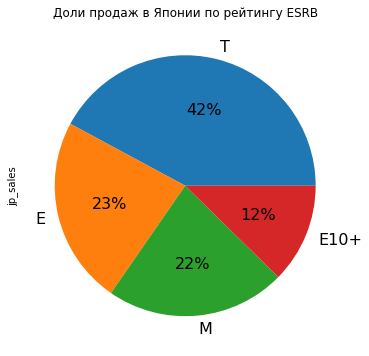

In [95]:
ax = (df_actual.groupby('rating')['jp_sales'].sum() / df_actual[df_actual['rating'].isna()==False]['jp_sales'].sum()).sort_values(ascending=False).plot(
    kind='pie', figsize=(12,6), autopct=lambda p: '{:.0f}%'.format(p), fontsize=16,
    title='Доли продаж в Японии по рейтингу ESRB')
plt.show()

В Японии доля игр 17+ (M) значительно меньше. И большие продажи происходят у категории T (подростковая), более 40%

### Вывод

Портреты пользователя в Европе и  Северной Америке почти не отличаются, здесь любят Action и Shooter, игры 17+, и платформы от Sony и Microsoft. В Японии же больше любят ролевые игры и игры в категории для подростков и предпочтиают своих производителей (Nintendo и Sony). 

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сравним распределения для этих платформ

In [96]:
df_user_score_xone = df_actual[df_actual['platform']=='XOne']['user_score'].dropna()

In [97]:
df_user_score_xone.var()

1.8910066518847013

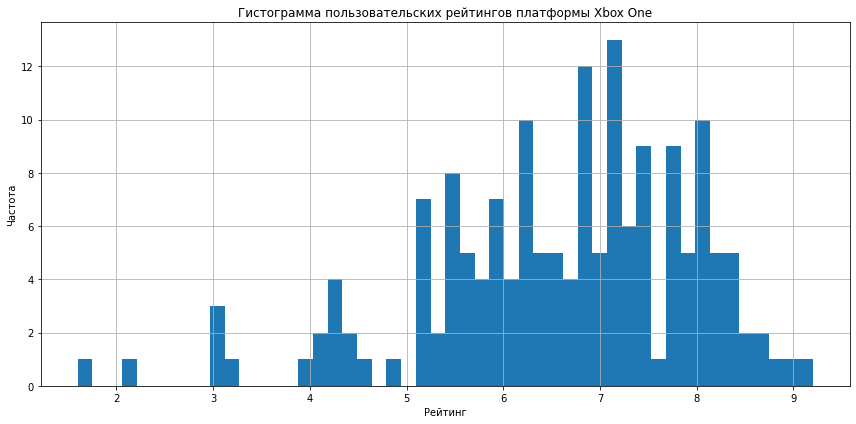

In [98]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df_user_score_xone, bins=50)
ax.set_xlabel('Рейтинг')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма пользовательских рейтингов платформы Xbox One')
ax.grid()
fig.tight_layout()
plt.show()

In [99]:
df_user_score_pc = df_actual[df_actual['platform']=='PC']['user_score'].dropna()

In [100]:
df_user_score_pc.var()

2.901154315133451

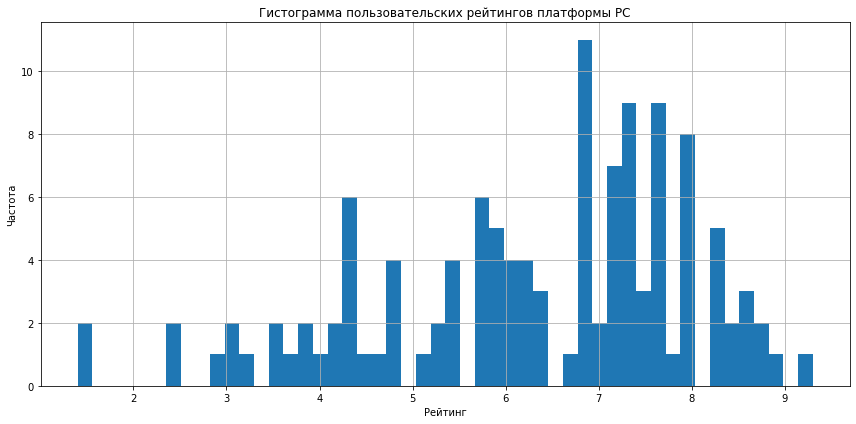

In [101]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df_user_score_pc, bins=50)
ax.set_xlabel('Рейтинг')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма пользовательских рейтингов платформы PC')
ax.grid()
fig.tight_layout()
plt.show()

Распределения для обеих платформ похожи на нормальное со скошенностью влево. Значения дисперсий близки.

Предположим, что их средние рейтинги платформ Xbox One и PC одинаковые (*нулевая гипотеза*), *альтернативная гипотеза*, что средние рейтинги платформ отличаются. Применим одностороннее t-тестирование.

Возьмём критический уровень статистической значимости 5%

In [102]:
alpha = 0.05

In [103]:
results = st.ttest_ind(df_user_score_xone, df_user_score_pc, equal_var = True)

In [104]:
'pvalue = {:.3f}'.format(results.pvalue)

'pvalue = 0.105'

pvalue > alpha, поэтому не отвергаем нулевую гипотезу. Скорее всего  **средние рейтинги платформ Xbox One и PC равны**.

In [105]:
df_user_score_pc.mean()

6.298360655737705

In [106]:
df_user_score_xone.mean()

6.594545454545456

### Средние пользовательские рейтинги жанров Action и Sports разные

Сравним распределения для этих платформ

In [107]:
df_user_score_action = df_actual[df_actual['genre']=='Action']['user_score'].dropna()

In [108]:
df_user_score_action.var()

1.8984766584766581

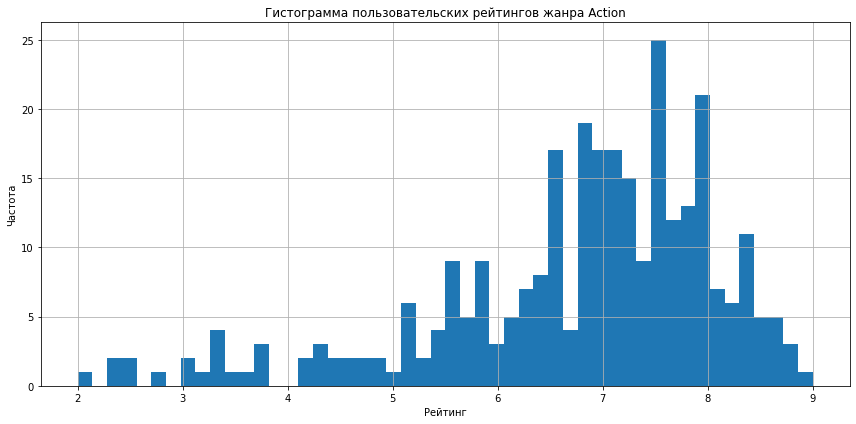

In [109]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df_user_score_action, bins=50)
ax.set_xlabel('Рейтинг')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма пользовательских рейтингов жанра Action')
ax.grid()
fig.tight_layout()
plt.show()

In [110]:
df_user_score_sports = df_actual[df_actual['genre']=='Sports']['user_score'].dropna()

In [111]:
df_user_score_sports.var()

3.446979127609048

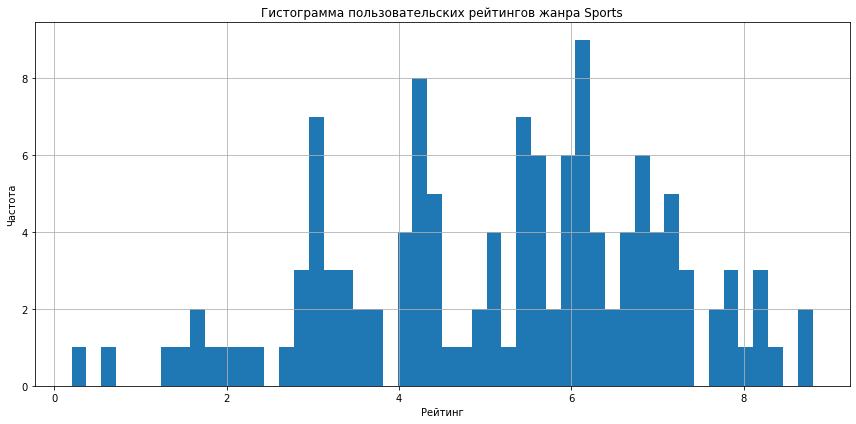

In [112]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df_user_score_sports, bins=50)
ax.set_xlabel('Рейтинг')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма пользовательских рейтингов жанра Sports')
ax.grid()
fig.tight_layout()
plt.show()

Распределения для обеих платформ похожи на нормальное со скошенностью влево. Значения дисперсий различаются почти в 2 раза.

Предположим, что их средние рейтинги жанров Action и Sports равны (*нулевая гипотеза*), альтернативная гипотеза, что средние рейтинги для жанров отличаются. Применим t-тестирование.

Возьмём критический уровень статистической значимости 5%

In [113]:
alpha = 0.05

In [114]:
results = st.ttest_ind(df_user_score_action, df_user_score_sports, equal_var = False)

In [115]:
'pvalue = {:.15f}'.format(results.pvalue)

'pvalue = 0.000000000000012'

pvalue < alpha, поэтому отвергаем нулевую гипотезу. Скорее всего  **средние рейтинги жанров Action и Sports различны**.

In [116]:
df_user_score_action.mean()

6.760606060606061

In [117]:
df_user_score_sports.mean()

5.2251968503937

## Общий вывод

В исследовании мы должны были выявить факторы, влияющие на продажи компьютерных игр и сформировать набор рекомендаций для планирования продаж на очередной год.

Отзывы пользователей и критиков игр слабо, но влияют на продажи.

В дополнительных исследованиях оценок пользователей сделаны выводы:

    1. средние рейтинги платформ Xbox One и PC не различаются
    2. средние рейтинги пользователей для жанров Action и Sports не равны, средний рейтинг пользователей для жанра Action скорее всего выше

С точки зрения платформ следует отдать приоритет следующим: **XOne** (Microsoft), **PS4** (Sony), которые имеют потенциал для роста продаж, так как платформы сравнительно новые. Небольшие продажи дополнительно могут обеспечить игры на платформах 3DS, PC и PSV.

### Северная Америка

Для Северной Америки можно отдать предпочтение как платформе **XOne**, так и **PS4**.

По жанрам предпочтительны **Action**, **Shooter**, **Sports** и игры по рейтингу ESRB в категории **M**

### Европа

Для Европы стоит отдать предпочтение платформе **PS4**.

По жанрам предпочтительны **Action**, **Shooter**, **Sports** и игры по рейтингу ESRB в категории **M**

### Япония

Для Японии стоит отдать предпочтение как **WiiU**, так и **PS4**.

По жанрам предпочтительны: **Role-Playing**, **Action** и игры по рейтингу ESRB в категориях **T**